# Common figure for the different resolutions (~ 100, 30 km)
## fig02

Original notebook: https://github.com/mickaellalande/PhD/blob/master/SCF_parameterizations/2_calibration/figure_HMASR_100_30_topo_std_weights.ipynb

conda env: `phd_v3`

In [1]:
# To reload external files automatically (ex: utils)
# phd_v3 env
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
plot.rc['abc.style'] = '(a)' # for EGU journals (only abc in new proplot versions)
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
# sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
sys.path.insert(1, '../utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


In [2]:
plot.version

'0.6.4'

## Load data

In [3]:
resolutions = ['100km', '30km']
dim = len(resolutions)
sd = [None]*dim
swe = [None]*dim
scf = [None]*dim
mask = [None]*dim
topo = [None]*dim
topo_std = [None]*dim

for i, res in enumerate(resolutions):
    path = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_'+res+'/'
    
    # Snow depth
    ds = xr.open_mfdataset(path+'HMA_SR_D_v01_'+res+'_WY*_SD_POST.nc')
    sd[i] = ds.SD_Post.load()

    # SCF
    ds = xr.open_mfdataset(path+'HMA_SR_D_v01_'+res+'_WY*_SWE_SCA_POST.nc')
    swe[i] = ds.SWE_Post.load()
    scf[i] = ds.SCA_Post.load()

    # Mask
    mask[i] = xr.open_dataarray('Non_seasonal_snow_mask_'+res+'.nc').load()
    mask[i]['lat'] = ds.lat # slight different round
    mask[i]['lon'] = ds.lon
    
    if res == '100km':
        # Topo
        latlim = slice(mask[i].lat.min().values.item(0)-0.5, mask[i].lat.max().values.item(0)+0.5)
        lonlim = slice(mask[i].lon.min().values.item(0)-0.5, mask[i].lon.max().values.item(0)+0.5)
        

    ds = xr.open_dataset('../data/HMASR_DEM_'+res+'.nc')
    topo[i] = ds.elevation_seassnow.load()
    topo_std[i] = ds.std_seassnow.load()

## Compute weights

In [4]:
weights_list = [None]*dim
for i in range(2):
    lat_weights = np.cos(np.deg2rad(scf[i].lat))
    frac_seasonal_snow = (1-mask[i]/100).where(scf[i][0]*0+1 == 1)
    temp = (frac_seasonal_snow*lat_weights).where(mask[i]<30)
#     weights = (temp / temp.sum()).fillna(0)
    weights = (temp).fillna(0)
#     np.testing.assert_almost_equal(weights.sum().values.item(0), 1)
    weights_list[i] = weights

## Plot

In [5]:
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

def plot_hatches_mask(ax, mask):
    mask_lats = []
    mask_lons = []

    threshold = 30
    delta = ((mask.lat[1]-mask.lat[0])/2).item(0)
    
    for lat in mask.lat.values:
        for lon in mask.lon.values:
            temp = mask.where(mask>threshold)*0+1
            if temp.sel(lat=lat, lon=lon) == 1:
                mask_lats.append(lat)
                mask_lons.append(lon)
    
    for i in range(len(mask_lats)):
        ax.add_patch(
                mpatches.Rectangle(
                    xy=[mask_lons[i]-delta, mask_lats[i]-delta], width=1, height=2*delta, transform=ccrs.PlateCarree(),
                    fill=False, zorder=10, color='black', linewidth=0, hatch='//////',
                )
            )

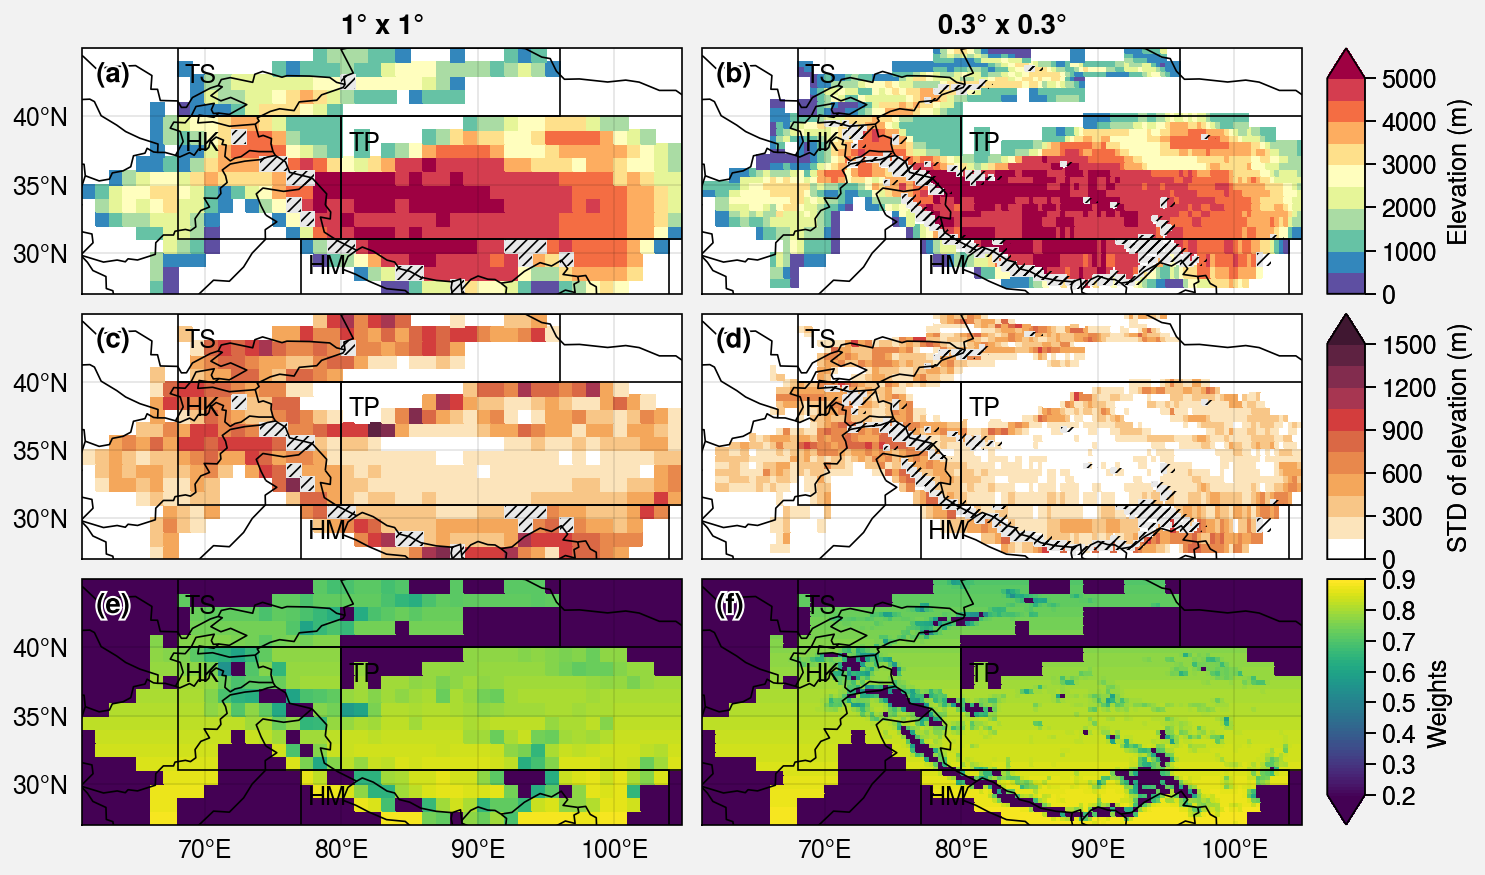

In [6]:
resolutions = ['1° x 1°', '0.3° x 0.3°']

fig, axs = plot.subplots(proj='cyl', ncols=2, nrows=3, axwidth=3, space=0.1)

k = 0
threshold = 30 # percentage of permanent snow in a cell

for i, res in enumerate(resolutions):
    m1 = axs[0, i].pcolormesh(topo[i].where(mask[i]<=threshold), cmap='Spectral_r', levels=plot.arange(0, 5000, 500), extend='max')
    m2 = axs[1, i].pcolormesh(topo_std[i].where(mask[i]<=threshold), levels=plot.arange(0, 1500, 150), extend='max')
    m3 = axs[2, i].pcolormesh(weights_list[i], levels=plot.arange(0.2, 0.9, 0.01), cmap='viridis', extend='min')
    
    # mask
    for j in range(2):
        axs[j, i].pcolormesh(mask[i].where(mask[i]>threshold)*0+1, cmap='lightgray', levels=[0, 1, 2, 3])
        plot_hatches_mask(axs[j, i], mask[i])

# zones       
for ax in axs:  
    u.plot_zones(ax)
    
fig.colorbar(m1, label='Elevation (m)', row=1, ticks=1000)
fig.colorbar(m2, label='STD of elevation (m)', row=2, ticks=300)
fig.colorbar(m3, label='Weights', row=3, ticks=0.1)

# Format
axs.format(
    borders=True, labels=True, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    abc=True, abcloc='ul',
    collabels=resolutions,
    latlines=5
)

axs.format()

for i in [1, 3, 5]:
    axs[i].format(
        latlabels=False
    )

for i in [0, 1, 2, 3]:
    axs[i].format(
        lonlabels=False
    )

for ext in ['jpg', 'pdf']:
    fig.save('img/fig02.'+ext)

## Make plot functions

### Compute weights
Taking into account:
- cos(lat)
- fraction of seasonal snow in a grid cell
- exclude cells with >30% of permanent snow

Weigths used to compute metrics (but not for optimization? -> maybe)

In [16]:
lat_weights = np.cos(np.deg2rad(scf[0].lat))
frac_seasonal_snow = (1-mask[0]/100).where(scf[0][0]*0+1 == 1)
temp = (frac_seasonal_snow*lat_weights).where(mask[0]<30)
weights = (temp / temp.sum()).fillna(0)
np.testing.assert_equal(weights.sum().values.item(0), 1)

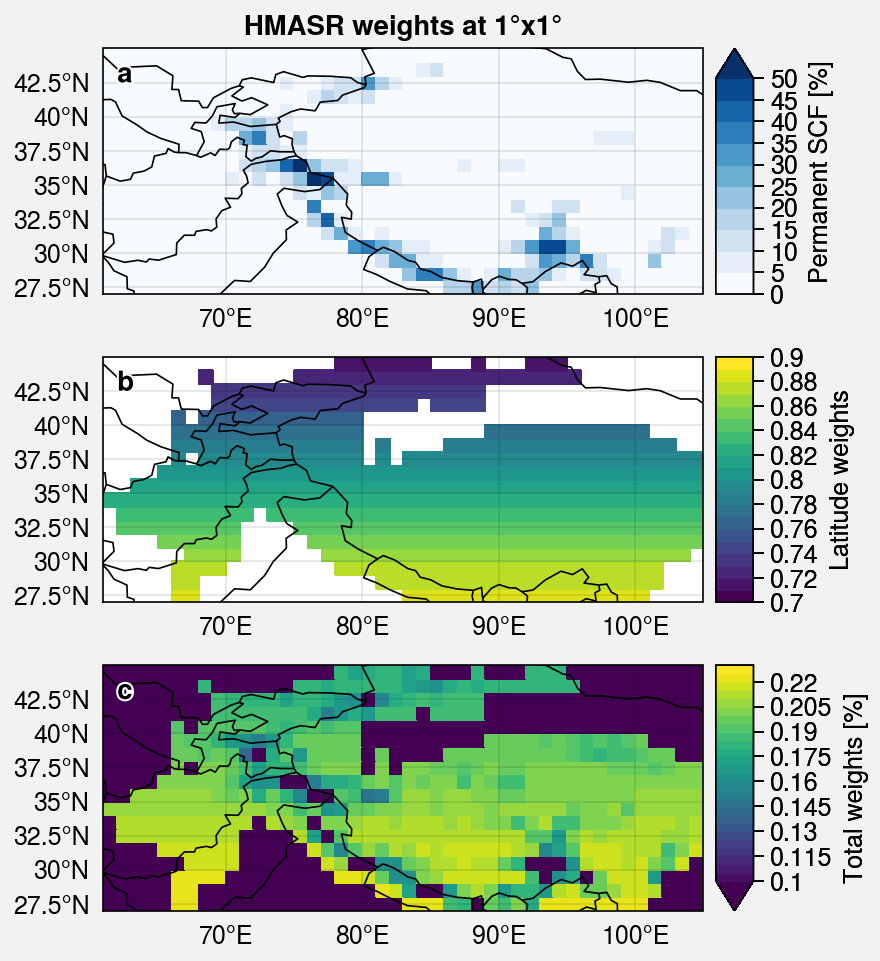

In [18]:
fig, axs = plot.subplots(proj='cyl', ncols=1, nrows=3, axwidth=3)

threshold = 30 # percentage of permanent snow in a cell

axs[0].pcolormesh(mask[0], levels=plot.arange(0, 50, 5), extend='max', cmap='Blues',
                 colorbar='r', colorbar_kw={'label': 'Permanent SCF [%]'})

axs[1].pcolormesh((scf[0][0]*0+1)*lat_weights, levels=plot.arange(0.7, 0.9, 0.01), cmap='viridis',
                 colorbar='r', colorbar_kw={'label': 'Latitude weights'})

axs[2].pcolormesh(weights*100, levels=plot.arange(0.0010, 0.0023, 0.00005)*100, cmap='viridis', extend='min',
                 colorbar='r', colorbar_kw={'label': 'Total weights [%]'})
# axs[2].format(title='Total weights (latitude + non-seasonal SCF\nwith >30% permanent snow grid cells excluded)')


# Format
axs.format(
    borders=True, labels=True, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    suptitle='HMASR weights at 1°x1°',
    abc=True, abcloc='ul'
)

# fig.save('img/weights.jpg')